In [1]:
import os
import sys
import time
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt, ticker
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, gps
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut

work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_gps'
os.chdir(work_dir)
print('Go to directory: '+work_dir)

site_r = 'GV01'

gps_dir = '/Users/yunjunz/insarlab/Galapagos/GPS'
pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'

ts_file = os.path.join(pysar_dir, 'geo_timeseries_ECMWF_demErr_refDate_plane.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
atr = ts_obj.metadata

geom_file = os.path.join(pysar_dir, 'geo_geometryRadar.h5')
inc_angle = readfile.read(geom_file, datasetName='incidenceAngle', print_msg=False)[0]
head_angle = readfile.read(geom_file, datasetName='headingAngle', print_msg=False)[0]

def read_timeseries(site, site_r=None):
    global inc_ang, head_ang, gps_obj, ts_obj
    ## Read GPS
    gps_obj = gps(site=site, data_dir=gps_dir)
    gps_obj.open(print_msg=False)
    
    y = ut.coord_geo2radar(gps_obj.site_lat, atr, 'lat')
    x = ut.coord_geo2radar(gps_obj.site_lon, atr, 'lon')
    inc_ang = inc_angle[y, x]
    head_ang = -1 * (180 + head_angle[y, x] + 90)

    gps_times = gps_obj.times
    gps_dis = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, heading_angle=head_ang, inc_angle=inc_ang)

    if site_r:
        gps_r_obj = gps(site=site_r, data_dir=gps_dir)
        gps_r_obj.open(print_msg=False)
        
        gps_times = sorted(list(set(gps_obj.times) & set(gps_r_obj.times)))
        dis_e = np.zeros(len(gps_times), np.float32)
        dis_n = np.zeros(dis_e.shape, np.float32)
        dis_u = np.zeros(dis_e.shape, np.float32)
        for i in range(len(gps_times)):
            idx1 = gps_obj.times.index(gps_times[i])
            idx2 = gps_r_obj.times.index(gps_times[i])
            dis_e[i] = gps_obj.dis_e[idx1] - gps_r_obj.dis_e[idx2]
            dis_n[i] = gps_obj.dis_n[idx1] - gps_r_obj.dis_n[idx2]
            dis_u[i] = gps_obj.dis_u[idx1] - gps_r_obj.dis_u[idx2]
        gps_dis = ut.enu2los(dis_e, dis_n, dis_u)

    ## Read InSAR
    box = (x, y, x+1, y+1)

    pysar_dis = ts_obj.read(box=box, print_msg=False)
    pysar_times = ts_obj.times

    if site_r:
        y_r = ut.coord_geo2radar(gps_r_obj.site_lat, atr, 'lat')
        x_r = ut.coord_geo2radar(gps_r_obj.site_lon, atr, 'lon')
        box_r = (x_r, y_r, x_r+1, y_r+1)
        pysar_dis -= ts_obj.read(box=box_r, print_msg=False)
    return gps_times, gps_dis, pysar_times, pysar_dis, gps_obj.site_lat, gps_obj.site_lon

## Plot
def plot_timeseries(ax, site, gps_times, gps_dis, pysar_times, pysar_dis, site_r=None,
                    disp_fig=True, offset=None, ylabel_fraction=None):
    title = 'Site={}'.format(site)
    if site_r:
          title += ', Ref Site={}'.format(site_r)
    comm_idx = 2
    while comm_idx < len(pysar_times):
        if pysar_times[comm_idx] not in gps_times:
            comm_idx += 1
        else:
            break
    if comm_idx == len(pysar_times):
        raise RuntimeError('InSAR and GPS do not share ANY date.')

    comm_date = pysar_times[comm_idx]
    #print('Common date: {}'.format(comm_date))
    pysar_dis -= pysar_dis[comm_idx]
    gps_dis -= gps_dis[gps_times.index(comm_date)]

    ax.scatter(gps_times, gps_dis-offset, s=1**2, label='GPS', color=pp.mplColors[0])
    ax.scatter(pysar_times, pysar_dis-offset, s=8**2, label='InSAR',
               facecolors='none', edgecolors=pp.mplColors[1], linewidth=1., alpha=0.7)
    
    ax.annotate('{}-{}'.format(site, site_r), xy=(1.03, ylabel_fraction),
                color='k', xycoords='axes fraction', fontsize=font_size)
    return ax

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_gps


Done.


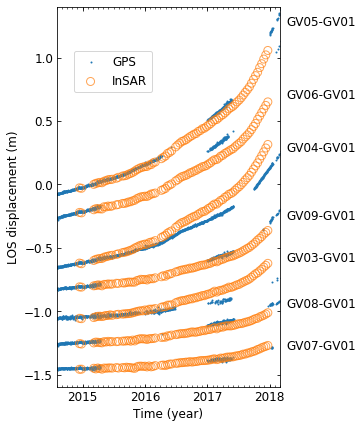

In [16]:
gps_sites = ['GV05', 'GV06', 'GV04', 'GV09', 'GV03', 'GV08', 'GV07']
offsets = np.array([0., 0.2, 0.4, 0.2, 0.25, 0.2, 0.2])
yfraction = [0.95, 0.76, 0.62, 0.44, 0.33, 0.21, 0.10]

#fig = plt.figure(figsize=(4, 10))
#ax = fig.add_axes((0.1, 0.05, 0.8, 0.7))
fig, ax = plt.subplots(figsize=(4, 7))

for i in range(len(gps_sites)):
    site = gps_sites[i]
    offset = np.sum(offsets[:i+1])
    (gps_times,
     gps_dis,
     pysar_times,
     pysar_dis) = read_timeseries(site=site, site_r=site_r)[0:4]
    ax = plot_timeseries(ax, site, gps_times, gps_dis, pysar_times, pysar_dis, site_r=site_r,
                         disp_fig=False, offset=offset, ylabel_fraction=yfraction[i])

ax = pp.auto_adjust_xaxis_date(ax, ts_obj.yearList)[0]
ax.set_ylim((-1.6, 1.4))
ax.set_xlabel('Time (year)', fontsize=font_size)
ax.set_ylabel('LOS displacement (m)', fontsize=font_size)
#ax.set_title('InSAR vs GPS', fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size,
               bottom=True, top=True, left=True, right=True)
ax.tick_params(labelsize=font_size, )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2], labels[0:2], loc='upper left', bbox_to_anchor=(0.05, 0.9), fontsize=font_size)
print('Done.')

plt.savefig('insar_vs_gps_point_ts.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

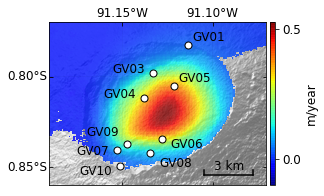

In [3]:
## map inset to show InSAR velocity field with GPS location on Sierra Negra
pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
vel_file = os.path.join(pysar_dir, 'geo_velocity_masked.h5')
dem_file = os.path.join(pysar_dir, '../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84')

#ax2 = fig.add_axes([0.1, 0.77, 0.8, 0.2])
fig, ax2 = plt.subplots(figsize=(5, 3))


# call view.py functions to plot InSAR background
from pysar import view
view_cmd = ('view.py {vf} velocity -l -0.86 -0.77 -L -91.19 -91.07 --mask no '
            '--dem {df} --dem-nocontour '
            '-u m --lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 3000 -0.854 -91.091 --figsize 4 2.5 '
            '-s 12 --notitle --dpi 600 -m -0.1 --cbar-nbins 1').format(vf=vel_file, df=dem_file)

inps = view.cmd_line_parse(view_cmd.split()[1:])
inps, atr = view.check_input_file_info(inps, print_msg=False)
inps = view.update_inps_with_file_metadata(inps, atr, print_msg=False)
data, atr = view.readfile.read(inps.file,
                               datasetName=inps.dset[0],
                               box=inps.pix_box,
                               print_msg=False)

ax2, inps, im = view.plot_2d_matrix(ax2, data, atr, inps, print_msg=False)


# plot GPS location with its label
gps_sites = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
lat_off = np.array([1,  0,  0,  1, -2,  -1, -3,   2,  -2]) * 0.05 / 20.
lon_off = np.array([1, -9, -9,  1,  2,  -9,  2,  -9,  -9]) * 0.05 / 20.

gps_lats = []
gps_lons = []
for site in gps_sites:
    lat, lon = gps(site=site, data_dir=gps_dir).get_stat_lat_lon(print_msg=False)
    gps_lats.append(lat)
    gps_lons.append(lon)
ax2.scatter(gps_lons, gps_lats, s=7**2, color='w', edgecolors='k')
for i in range(len(gps_sites)):
    ax2.annotate(gps_sites[i],
                 (gps_lons[i]+lon_off[i],
                  gps_lats[i]+lat_off[i]),
                 fontsize=font_size)

plt.savefig('insar_vs_gps_map.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()